# FC autoencoder for MNIST

My first experiment with autoencoders: a small network with fully connected layers to autoencode the MNIST data

## Imports

In [1]:
from fastai.vision.all import *

## Load data

In [2]:
path = untar_data(URLs.MNIST_TINY)

In [3]:
path/'training'

Path('/Users/bauville/.fastai/data/mnist_tiny/training')

In [4]:
def label_func(o):
    img = image2tensor(Image.open(o))
    tf = RandomCrop(28)
    img = tf(img)
    img = img.view(1,784).float()
    img /= 255.0
    return img

dblock = DataBlock(blocks=(ImageBlock(cls=PILImageBW), RegressionBlock),
                   get_items=get_image_files, 
                   splitter=GrandparentSplitter(),
                   get_y=label_func,
                   get_x=label_func)

dls = dblock.dataloaders(path)

## Create architecture

In [5]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784,128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
            nn.Linear(18, 9),
        )

        self.decoder = nn.Sequential(
            nn.Linear(9,18),
            nn.ReLU(),
            # nn.Dropout2d(0.5),
            nn.Linear(18,36),
            nn.ReLU(),
            # nn.Dropout2d(0.5),
            nn.Linear(36,64),
            nn.ReLU(),
            # nn.Dropout2d(0.5),
            nn.Linear(64,128),
            nn.ReLU(),
            # nn.Dropout2d(0.5),
            nn.Linear(128,784),
            # nn.Dropout2d(0.5),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create Learner

In [6]:
learn = Learner(dls, AE(), loss_func=MSELossFlat())

In [7]:
# learn.lr_find()
learn.fit(20, lr=0.002)

epoch,train_loss,valid_loss,time
0,0.219541,0.198818,00:02
1,0.186007,0.106284,00:00
2,0.140890,0.068361,00:00
3,0.114860,0.066078,00:00
4,0.099329,0.064718,00:00
5,0.089151,0.063769,00:00
6,0.082110,0.063581,00:00
7,0.077042,0.063320,00:00
8,0.073309,0.063156,00:00
9,0.070510,0.063098,00:00


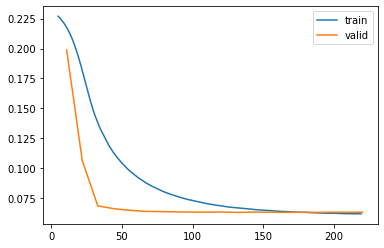

In [8]:
learn.recorder.plot_loss()

Text(0.5, 1.0, 'Predictions')

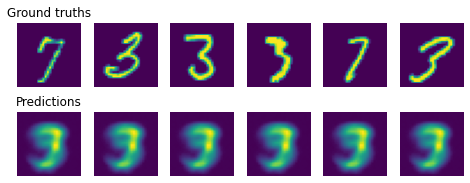

In [9]:
import torchvision.transforms as T
b = dls.one_batch()
_,_,preds = learn.get_preds(dl=[b], with_decoded=True)
n = 6
fig, ax = plt.subplots(2,n, figsize= [8,3])
for i in range(n):
    s = i
    plt.axes(ax[0,i])
    plt.imshow(b[1][s,:].view(28,28).cpu())
    plt.axis('off')
    plt.axes(ax[1,i])
    plt.imshow(preds[s,:].view(28,28).cpu())
    plt.axis('off')

plt.axes(ax[0,0])
plt.title("Ground truths")

plt.axes(ax[1,0])
plt.title("Predictions")